In [1]:
%pip install pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


# Importing required libraires

In [2]:
# paytorch packages
import torch
from torch import nn
import torch.quantization
import pytorch_lightning as pl
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, Callback
from pytorch_lightning.loggers import TensorBoardLogger

# general packages
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Downloading the dataset for CNN neural networks

In [3]:
filename = 'CNN.csv'
url = "https://www.dropbox.com/scl/fi/x2eh2yil56rgu5id1fwbm/cnn_data1.csv?rlkey=7bltxkitlwdnuirw08r2ysuv4&st=nppxtfhe&dl=1"
response = requests.get(url)

# Save the file locally
with open(filename, 'wb') as file:
    file.write(response.content)

# Looking into the dataset functions

## Looking into the dataframe's columns distribution

In [4]:
def plot_data_hist(df, exclude_columns=None):
    if exclude_columns is None:
        exclude_columns = []

    # Drop excluded columns
    columns = [col for col in df.columns if col not in exclude_columns]

    n_cols = 3
    n_rows = int(np.ceil(len(columns) / n_cols))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), dpi=80)
    axs = axs.ravel()

    for i, col in enumerate(columns):
        axs[i].hist(df[col].dropna(), bins=30)
        axs[i].set_xlabel(col)
        axs[i].set_ylabel('count')

    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# Summarizing columns

In [5]:
def summarize_columns(df):
    for col in df.columns:
        if pd.api.types.is_numeric_dtype(df[col]):
            print(f'{col} | max: {df[col].max()} | min: {df[col].min()}')
    print('len dataset:', len(df))

# Looking into the output variable historgram

In [6]:
def plot_hist_with_counts(df, column, bins=5):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in DataFrame.")

    ax = df[column].plot.hist(bins=bins)

    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        bin_center = patch.get_x() + width / 2
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    plt.tight_layout()
    plt.show()

In [7]:
csv_file_path = filename  # Replace with the actual path to the produced CSV file

# Load the CSV into a DataFrame and assign it to the desired column names
df = pd.read_csv(csv_file_path)

df.head()

,Filename,Depth,Activations-Params,Activation Function,Total Activations,Total Parameters,Batch Size,Max GPU Memory (MiB),Avg GPUTL,Avg GRACT,...,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Status,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),architecture
0,input_channels:3_num_classes:453_depth:22_arch...,69,"[('conv2d', 183956976, 2744), ('GELU', 1839569...",GELU,195826172,1864805,62,39517,-1.000000,-1.000000,...,0,22,1,1,SUCCESSFUL,21.70,123506.48,7.11,123535.29,uniform
1,input_channels:1_num_classes:167_depth:11_arch...,47,"[('conv2d', 44835280, 700), ('batchnorm2d', 44...",SELU,306385536,32924348,46,36831,-1.000000,-1.000000,...,11,11,1,1,OOM_CRASH,2.30,134408.32,125.60,134536.22,pyramid
2,input_channels:3_num_classes:99_depth:14_arch:...,31,"[('conv2d', 33323400, 3388), ('ELU', 33323400,...",ELU,27443119,1730036,34,6293,90.222222,0.913875,...,0,0,1,1,SUCCESSFUL,3.06,10678.04,6.60,10687.70,uniform
3,input_channels:3_num_classes:95_depth:16_arch:...,67,"[('conv2d', 18688000, 2044), ('batchnorm2d', 1...",ELU,119603463,731920,10,6475,93.703125,0.932032,...,16,16,1,1,SUCCESSFUL,2.90,11406.30,2.79,11411.99,uniform
4,input_channels:1_num_classes:149_depth:12_arch...,39,"[('conv2d', 2230272, 640), ('batchnorm2d', 223...",ReLU,11111315,2960902,18,2779,88.328125,0.864873,...,12,0,1,1,SUCCESSFUL,0.18,2034.54,11.29,2046.01,gradual


# Adding (total-activations * batch-size) to the data as another feature!
## 1. The OOM crashed configurations mean that they wanted more than 40GB (Memory Capacity of NVIDIA A100 GPU).
## 2. filtering out residual and dense architectures for initial analysis as parsing the features out of them requires being careful!

In [8]:
df['Total_Activations_Batch_Size'] = df['Total Activations'] * df['Batch Size']
df.loc[df['Status'] == 'OOM_CRASH', 'Max GPU Memory (MiB)'] = 42000



df = df.dropna(subset=['Activation Function'])

df = df[~df['architecture'].isin(['residual', 'dense'])]


df = df[['Depth', 'Activation Function', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
               'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
               'Linear Count', 'Max GPU Memory (MiB)', 'architecture',
               'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)']]


columns_to_analyze = ['Depth', 'Activation Function', 'Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
                        'Conv2d Count','BatchNorm2d Count', 'Dropout Count', 'AdaptiveAvgPool2d Count',
                        'Linear Count', 'Max GPU Memory (MiB)', 'architecture',
                        'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)']

Depth | max :  119 | min:  5
Activation Function | max :  Tanh | min:  ELU
Total Activations | max :  5317481490 | min:  24514
Total_Activations_Batch_Size | max :  258908974214 | min:  208120
Total Parameters | max :  329307377 | min:  704
Batch Size | max :  62 | min:  2
Conv2d Count | max :  29 | min:  1
BatchNorm2d Count | max :  29 | min:  0
Dropout Count | max :  29 | min:  0
AdaptiveAvgPool2d Count | max :  1 | min:  1
Linear Count | max :  1 | min:  1
Max GPU Memory (MiB) | max :  42000 | min:  1703
architecture | max :  uniform | min:  bottleneck
Input Size (MB) | max :  35.34 | min:  0.0
Forward/Backward Pass Size (MB) | max :  2633757.52 | min:  2.0
Params Size (MB) | max :  1256.21 | min:  0.0
Estimated Total Size (MB) | max :  2634907.67 | min:  2.11
len dataset:  6516


<Figure size 10000x800 with 0 Axes>

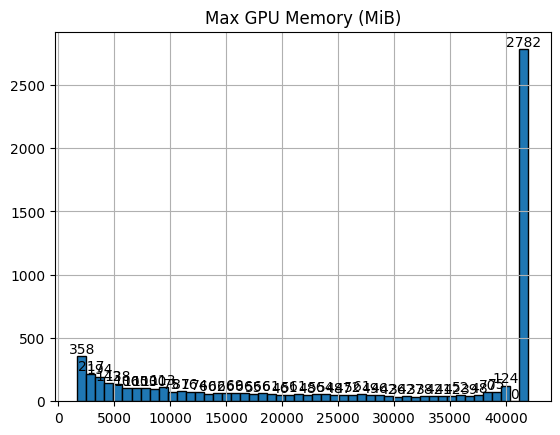

In [9]:
for col in columns_to_analyze:
    if col == 'activation_function':
      continue
    print(f'{col} | max : ', df[col].max(), '| min: ', df[col].min())
print('len dataset: ', len(df))


# Plotting the histogram of 'Max GPU Memory (MiB)' with increased figure size and labeled bins
plt.figure(figsize=(100, 8))  # Increase the size of the figure
ax = df[['Max GPU Memory (MiB)']].hist(bins=50, edgecolor='black')

# Adding labels to the bins
for ax in plt.gcf().axes:
    for patch in ax.patches:
        # Get the coordinates and height of each bar (bin)
        height = patch.get_height()
        width = patch.get_width()
        # Calculate the position where the text will be displayed
        bin_center = patch.get_x() + width / 2
        # Display the height (number of items in each bin)
        ax.text(bin_center, height, int(height), ha='center', va='bottom')

plt.show()

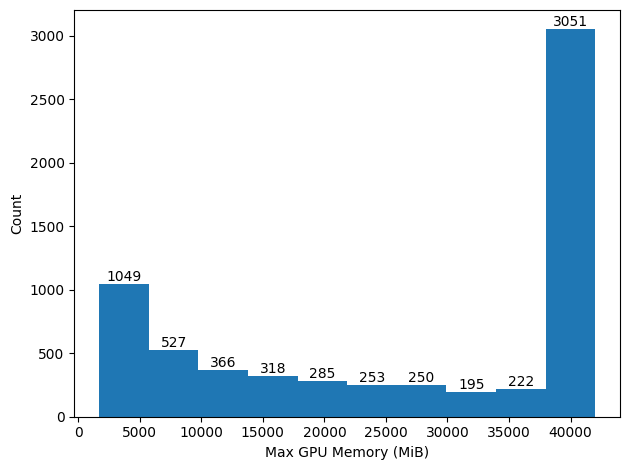

In [10]:
plot_hist_with_counts(df, 'Max GPU Memory (MiB)', 10)

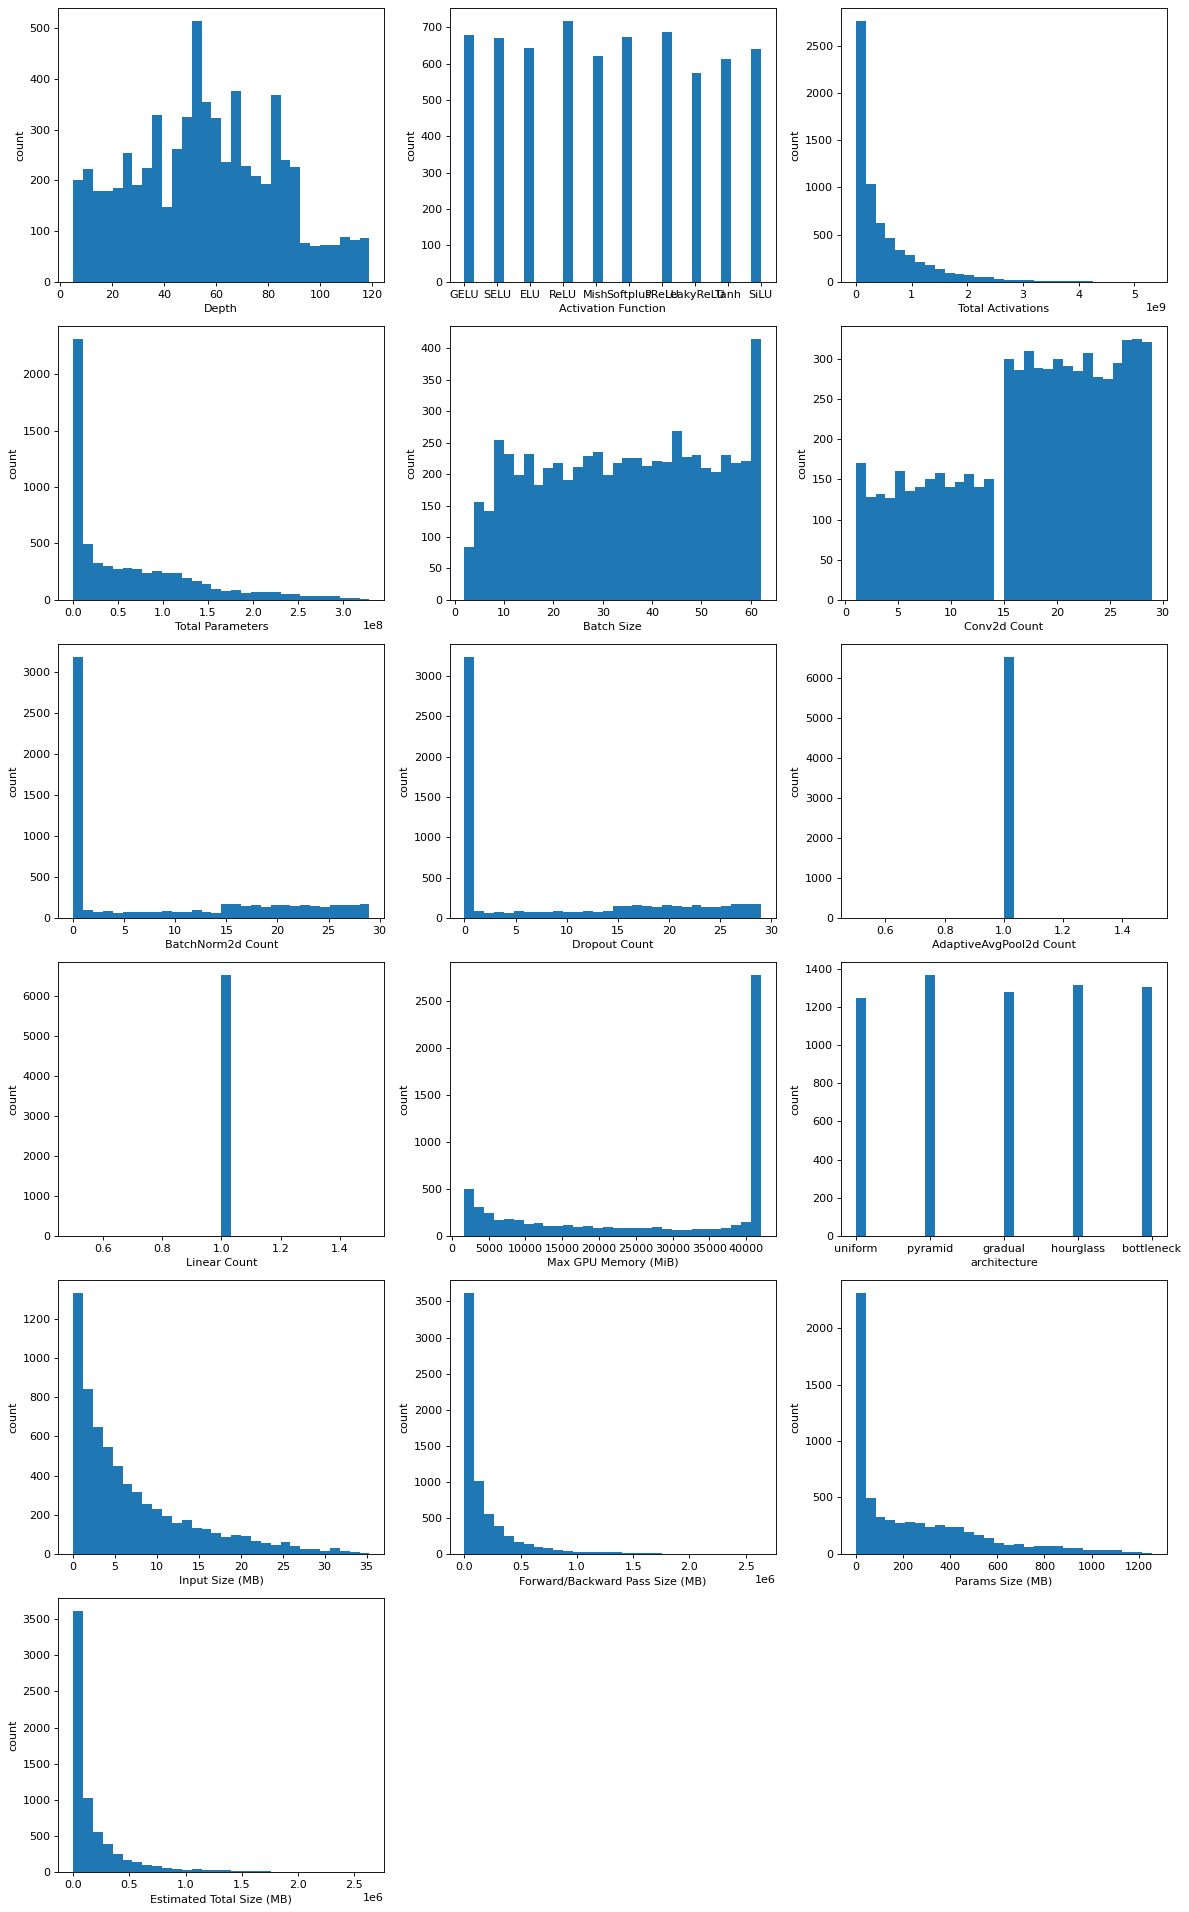

In [11]:
plot_data_hist(df, exclude_columns=['Total_Activations_Batch_Size'])

# having activations functions as two separate columns

In [12]:
# List of activation functions
activations = ['ELU', 'GELU', 'LeakyReLU', 'Mish', 'PReLU', 'ReLU', 'SELU', 'SiLU', 'Softplus', 'Tanh']

# Function to create positional encoding
def positional_encoding_2d(num_states):
    positions = []
    for i in range(num_states):
        position = (np.sin(i * np.pi / num_states), np.cos(i * np.pi / num_states))
        positions.append(position)
    return np.array(positions)

# Generate positional encodings
positional_encodings = positional_encoding_2d(len(activations))
activation_to_encoding = {activation: positional_encodings[i] for i, activation in enumerate(activations)}

# Apply positional encoding to 'activation_function' column
df['activation_encoding_sin'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][0])
df['activation_encoding_cos'] = df['Activation Function'].map(lambda x: activation_to_encoding[x][1])

# Data after encoding activation functions

In [13]:
df.head()

,Depth,Activation Function,Total Activations,Total_Activations_Batch_Size,Total Parameters,Batch Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Max GPU Memory (MiB),architecture,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos
0,69,GELU,195826172,12141222664,1864805,62,22,0,22,1,1,39517,uniform,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01
1,47,SELU,306385536,14093734656,32924348,46,11,11,11,1,1,42000,pyramid,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01
2,31,ELU,27443119,933066046,1730036,34,14,0,0,1,1,6293,uniform,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00
3,67,ELU,119603463,1196034630,731920,10,16,16,16,1,1,6475,uniform,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00
4,39,ReLU,11111315,200003670,2960902,18,12,12,0,1,1,2779,gradual,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17


# classification

In [14]:
bins = [0, 8000, 16000, 24000, 32000, 40000, 48000]
labels = [i for i in range(0, len(bins) - 1)]


print("Bins: ", bins, "Number of bins: ", len(bins))
print("Labels: ", labels, "Number of labels: ", len(labels))

df['memory_usage_label'] = pd.cut(df['Max GPU Memory (MiB)'], bins=bins, labels=labels, right=True)

df.head()

Bins:  [0, 8000, 16000, 24000, 32000, 40000, 48000] Number of bins:  7
Labels:  [0, 1, 2, 3, 4, 5] Number of labels:  6


,Depth,Activation Function,Total Activations,Total_Activations_Batch_Size,Total Parameters,Batch Size,Conv2d Count,BatchNorm2d Count,Dropout Count,AdaptiveAvgPool2d Count,Linear Count,Max GPU Memory (MiB),architecture,Input Size (MB),Forward/Backward Pass Size (MB),Params Size (MB),Estimated Total Size (MB),activation_encoding_sin,activation_encoding_cos,memory_usage_label
0,69,GELU,195826172,12141222664,1864805,62,22,0,22,1,1,39517,uniform,21.70,123506.48,7.11,123535.29,0.309017,9.510565e-01,4
1,47,SELU,306385536,14093734656,32924348,46,11,11,11,1,1,42000,pyramid,2.30,134408.32,125.60,134536.22,0.951057,-3.090170e-01,5
2,31,ELU,27443119,933066046,1730036,34,14,0,0,1,1,6293,uniform,3.06,10678.04,6.60,10687.70,0.000000,1.000000e+00,0
3,67,ELU,119603463,1196034630,731920,10,16,16,16,1,1,6475,uniform,2.90,11406.30,2.79,11411.99,0.000000,1.000000e+00,0
4,39,ReLU,11111315,200003670,2960902,18,12,12,0,1,1,2779,gradual,0.18,2034.54,11.29,2046.01,1.000000,6.123234e-17,0


In [15]:
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp = train_test_split(
    df[['Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
        'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
        'activation_encoding_cos',
        # 'Input Size (MB)', 'Forward/Backward Pass Size (MB)','Params Size (MB)', 'Estimated Total Size (MB)',
        ]].values, df['memory_usage_label'].values, test_size=0.3, random_state=42)

x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.66, random_state=42)

print('total data size: ', len(df))
print(f"train size {len(x_train)}, val size: {len(x_val)}, test size: {len(x_test)}")

total data size:  6516
train size 4561, val size: 1291, test size: 664


In [16]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        # Store the input and target data
        self.inputs = torch.tensor(inputs, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        # Returns the total number of samples
        return len(self.inputs)

    def __getitem__(self, idx):
        # Return a single sample (input, target pair)
        return self.inputs[idx], self.targets[idx]

train_dataloader = DataLoader(CustomDataset(x_train, y_train), 512, num_workers=2, shuffle=True)
val_dataloader = DataLoader(CustomDataset(x_val, y_val), 512, num_workers=2)
test_dataloader = DataLoader(CustomDataset(x_test, y_test),1, num_workers=1)
x, y = next(iter(train_dataloader))
print(f"input shape: {x.shape}, output shape: {y.shape}")

input shape: torch.Size([512, 9]), output shape: torch.Size([512])


In [17]:
class FC_base(nn.Module):
    def __init__(self, input_features, output_features, base_features):
        super(FC_base, self).__init__()

        # Define the network architecture
        self.fc1 = nn.Linear(input_features, base_features)
        self.bn1 = nn.BatchNorm1d(base_features)
        self.fc2 = nn.Linear(base_features, base_features)
        self.bn2 = nn.BatchNorm1d(base_features)
        self.fc3 = nn.Linear(base_features, base_features)
        self.bn3 = nn.BatchNorm1d(base_features)
        self.fc4 = nn.Linear(base_features, base_features)
        self.bn4 = nn.BatchNorm1d(base_features)
        self.fc5 = nn.Linear(base_features, base_features//2)
        self.bn5 = nn.BatchNorm1d(base_features//2)
        self.fc6 = nn.Linear(base_features//2, base_features//2)
        self.bn6 = nn.BatchNorm1d(base_features//2)

        self.final = nn.Linear(base_features//2, output_features)
        # self.dropout = nn.Dropout(p=0.0)
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.bn4(self.fc4(x)))
        x = self.relu(self.bn5(self.fc5(x)))
        x = self.relu(self.bn6(self.fc6(x)))
        x = self.final(x)
        return x

In [18]:
from pytorch_lightning import seed_everything

seed = 11  # Set your desired seed
seed_everything(seed, workers=True)
torch.use_deterministic_algorithms(False)


Seed set to 11


In [19]:
class classification_gpu_usage(pl.LightningModule):
    def __init__(self, output_size):
        super(classification_gpu_usage, self).__init__()
        # Define your model
        self.model = FC_base(input_features=9, output_features=output_size, base_features=8)
        self.criterion = nn.CrossEntropyLoss()
        # self.criterion = nn.BCEWithLogitsLoss()
        self.output_size = output_size

        # Apply weight initialization
        self.apply(self._initialize_weights)

    def _initialize_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)  # Xavier uniform initialization
            if module.bias is not None:
                nn.init.zeros_(module.bias)  # Initialize bias to zeros


    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()
        # Apply label smoothing to the target labels
        # smoothed_labels = smooth_labels(y, self.output_size, self.smoothing)

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."


        logits = self.forward(x)
        loss = self.criterion(logits, y)

        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('train_loss', loss, on_epoch=True, on_step=False)
        self.log('train_acc', acc, on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y = y.long()

        # assert (y >= 0).all() and (y < self.output_size).all(), "Labels are out of bounds."

        logits = self.forward(x)
        loss = self.criterion(logits, y)
        # Calculate accuracy
        acc = (logits.argmax(dim=1) == y).float().mean()

        # Log loss and accuracy
        self.log('val_loss', loss, on_epoch=True, on_step=False, prog_bar=True)
        self.log('val_acc', acc, on_epoch=True, on_step=False, prog_bar=True)

        return loss

    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=0.001)

        # Use a scheduler that doesn't require setting the learning rate explicitly
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)#, verbose=True)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'frequency': 1
            }
        }
        # return optimizer

In [20]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)
print(len(labels))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=True, mode='min')


classifier_model = classification_gpu_usage(output_size = len(labels)).to(device)

summary(classifier_model, input_size=(9,), device=device)

cuda
6
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 8]              80
       BatchNorm1d-2                    [-1, 8]              16
              ReLU-3                    [-1, 8]               0
            Linear-4                    [-1, 8]              72
       BatchNorm1d-5                    [-1, 8]              16
              ReLU-6                    [-1, 8]               0
            Linear-7                    [-1, 8]              72
       BatchNorm1d-8                    [-1, 8]              16
              ReLU-9                    [-1, 8]               0
           Linear-10                    [-1, 8]              72
      BatchNorm1d-11                    [-1, 8]              16
             ReLU-12                    [-1, 8]               0
           Linear-13                    [-1, 4]              36
      BatchNorm1d-14            

In [21]:
class HistoryCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_train_epoch_end(self, trainer, pl_module):
        # Access the training loss and accuracy logged during the epoch
        self.train_losses.append(trainer.callback_metrics["train_loss"].item())
        self.train_accuracies.append(trainer.callback_metrics["train_acc"].item())

    def on_validation_epoch_end(self, trainer, pl_module):
        # Access the validation loss and accuracy logged during the epoch
        self.val_losses.append(trainer.callback_metrics["val_loss"].item())
        self.val_accuracies.append(trainer.callback_metrics["val_acc"].item())

    def plot_history(self):
        # Plot training and validation loss
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.val_losses, label="Validation Loss")
        plt.title("Loss Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        # Plot training and validation accuracy
        plt.subplot(1, 2, 2)
        plt.plot(self.train_accuracies, label="Training Accuracy")
        plt.plot(self.val_accuracies, label="Validation Accuracy")
        plt.title("Accuracy Over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()

In [22]:
# Initialize the history callback
history_callback = HistoryCallback()

classifier_model.train()

classifier_model.train()
trainer = pl.Trainer(
    max_epochs=600,
    callbacks=[early_stopping, history_callback],
)
# Train the model
trainer.fit(classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Ple

/opt/miniconda3/envs/dl/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 9/9 [00:00<00:00, 22.67it/s, v_num=7, val_loss=1.780, val_acc=0.154]

Metric val_loss improved. New best score: 1.777


Epoch 1: 100%|██████████| 9/9 [00:00<00:00, 20.92it/s, v_num=7, val_loss=1.720, val_acc=0.297]

Metric val_loss improved by 0.054 >= min_delta = 0.0. New best score: 1.724


Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 19.24it/s, v_num=7, val_loss=1.660, val_acc=0.503]

Metric val_loss improved by 0.062 >= min_delta = 0.0. New best score: 1.661


Epoch 3: 100%|██████████| 9/9 [00:00<00:00, 18.48it/s, v_num=7, val_loss=1.600, val_acc=0.534]

Metric val_loss improved by 0.064 >= min_delta = 0.0. New best score: 1.597


Epoch 4: 100%|██████████| 9/9 [00:00<00:00, 20.51it/s, v_num=7, val_loss=1.520, val_acc=0.508]

Metric val_loss improved by 0.075 >= min_delta = 0.0. New best score: 1.522


Epoch 5: 100%|██████████| 9/9 [00:00<00:00, 16.88it/s, v_num=7, val_loss=1.500, val_acc=0.572]

Metric val_loss improved by 0.018 >= min_delta = 0.0. New best score: 1.504


Epoch 6: 100%|██████████| 9/9 [00:00<00:00, 19.16it/s, v_num=7, val_loss=1.440, val_acc=0.557]

Metric val_loss improved by 0.067 >= min_delta = 0.0. New best score: 1.438


Epoch 7: 100%|██████████| 9/9 [00:00<00:00, 18.50it/s, v_num=7, val_loss=1.420, val_acc=0.618]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 1.422


Epoch 8: 100%|██████████| 9/9 [00:00<00:00, 17.38it/s, v_num=7, val_loss=1.380, val_acc=0.613]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 1.384


Epoch 9: 100%|██████████| 9/9 [00:00<00:00, 17.96it/s, v_num=7, val_loss=1.370, val_acc=0.655]

Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 1.374


Epoch 10: 100%|██████████| 9/9 [00:00<00:00, 19.29it/s, v_num=7, val_loss=1.330, val_acc=0.684]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 1.329


Epoch 11: 100%|██████████| 9/9 [00:00<00:00, 16.53it/s, v_num=7, val_loss=1.300, val_acc=0.679]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 1.304


Epoch 12: 100%|██████████| 9/9 [00:00<00:00, 16.42it/s, v_num=7, val_loss=1.270, val_acc=0.659]

Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 1.271


Epoch 13: 100%|██████████| 9/9 [00:00<00:00, 19.93it/s, v_num=7, val_loss=1.220, val_acc=0.665]

Metric val_loss improved by 0.051 >= min_delta = 0.0. New best score: 1.220


Epoch 14: 100%|██████████| 9/9 [00:00<00:00, 18.91it/s, v_num=7, val_loss=1.170, val_acc=0.655]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 1.170


Epoch 15: 100%|██████████| 9/9 [00:00<00:00, 17.81it/s, v_num=7, val_loss=1.110, val_acc=0.648]

Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.115


Epoch 16: 100%|██████████| 9/9 [00:00<00:00, 17.16it/s, v_num=7, val_loss=1.040, val_acc=0.649]

Metric val_loss improved by 0.074 >= min_delta = 0.0. New best score: 1.041


Epoch 17: 100%|██████████| 9/9 [00:00<00:00, 17.68it/s, v_num=7, val_loss=1.000, val_acc=0.647]

Metric val_loss improved by 0.036 >= min_delta = 0.0. New best score: 1.005


Epoch 18: 100%|██████████| 9/9 [00:00<00:00, 21.58it/s, v_num=7, val_loss=0.986, val_acc=0.635]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.986


Epoch 19: 100%|██████████| 9/9 [00:00<00:00, 17.30it/s, v_num=7, val_loss=0.936, val_acc=0.649]

Metric val_loss improved by 0.050 >= min_delta = 0.0. New best score: 0.936


Epoch 20: 100%|██████████| 9/9 [00:00<00:00, 18.51it/s, v_num=7, val_loss=0.909, val_acc=0.649]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.909


Epoch 21: 100%|██████████| 9/9 [00:00<00:00, 19.63it/s, v_num=7, val_loss=0.887, val_acc=0.651]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.887


Epoch 22: 100%|██████████| 9/9 [00:00<00:00, 19.62it/s, v_num=7, val_loss=0.871, val_acc=0.655]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.871


Epoch 23: 100%|██████████| 9/9 [00:00<00:00, 18.22it/s, v_num=7, val_loss=0.858, val_acc=0.658]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.858


Epoch 25: 100%|██████████| 9/9 [00:00<00:00, 17.83it/s, v_num=7, val_loss=0.831, val_acc=0.675]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.831


Epoch 26: 100%|██████████| 9/9 [00:00<00:00, 21.07it/s, v_num=7, val_loss=0.814, val_acc=0.692]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.814


Epoch 27: 100%|██████████| 9/9 [00:00<00:00, 18.31it/s, v_num=7, val_loss=0.799, val_acc=0.698]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.799


Epoch 28: 100%|██████████| 9/9 [00:00<00:00, 19.46it/s, v_num=7, val_loss=0.790, val_acc=0.699]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.790


Epoch 29: 100%|██████████| 9/9 [00:00<00:00, 22.17it/s, v_num=7, val_loss=0.782, val_acc=0.703]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.782


Epoch 31: 100%|██████████| 9/9 [00:00<00:00, 17.39it/s, v_num=7, val_loss=0.775, val_acc=0.713]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.775


Epoch 32: 100%|██████████| 9/9 [00:00<00:00, 18.63it/s, v_num=7, val_loss=0.756, val_acc=0.710]

Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.756


Epoch 33: 100%|██████████| 9/9 [00:00<00:00, 19.03it/s, v_num=7, val_loss=0.749, val_acc=0.711]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.749


Epoch 34: 100%|██████████| 9/9 [00:00<00:00, 17.86it/s, v_num=7, val_loss=0.735, val_acc=0.710]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.735


Epoch 35: 100%|██████████| 9/9 [00:00<00:00, 18.96it/s, v_num=7, val_loss=0.733, val_acc=0.714]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.733


Epoch 36: 100%|██████████| 9/9 [00:00<00:00, 17.91it/s, v_num=7, val_loss=0.728, val_acc=0.714]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.728


Epoch 37: 100%|██████████| 9/9 [00:00<00:00, 17.75it/s, v_num=7, val_loss=0.716, val_acc=0.720]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.716


Epoch 39: 100%|██████████| 9/9 [00:00<00:00, 17.70it/s, v_num=7, val_loss=0.705, val_acc=0.719]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.705


Epoch 42: 100%|██████████| 9/9 [00:00<00:00, 18.68it/s, v_num=7, val_loss=0.697, val_acc=0.718]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.697


Epoch 44: 100%|██████████| 9/9 [00:00<00:00, 18.61it/s, v_num=7, val_loss=0.685, val_acc=0.723]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.685


Epoch 46: 100%|██████████| 9/9 [00:00<00:00, 18.11it/s, v_num=7, val_loss=0.681, val_acc=0.723]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.681


Epoch 47: 100%|██████████| 9/9 [00:00<00:00, 17.30it/s, v_num=7, val_loss=0.679, val_acc=0.718]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.679


Epoch 48: 100%|██████████| 9/9 [00:00<00:00, 20.24it/s, v_num=7, val_loss=0.667, val_acc=0.725]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.667


Epoch 50: 100%|██████████| 9/9 [00:00<00:00, 20.85it/s, v_num=7, val_loss=0.660, val_acc=0.726]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.660


Epoch 54: 100%|██████████| 9/9 [00:00<00:00, 17.26it/s, v_num=7, val_loss=0.644, val_acc=0.724]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.644


Epoch 55: 100%|██████████| 9/9 [00:00<00:00, 19.07it/s, v_num=7, val_loss=0.639, val_acc=0.729]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.639


Epoch 57: 100%|██████████| 9/9 [00:00<00:00, 20.77it/s, v_num=7, val_loss=0.633, val_acc=0.727]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.633


Epoch 60: 100%|██████████| 9/9 [00:00<00:00, 15.99it/s, v_num=7, val_loss=0.626, val_acc=0.727]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.626


Epoch 62: 100%|██████████| 9/9 [00:00<00:00, 17.10it/s, v_num=7, val_loss=0.620, val_acc=0.730]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.620


Epoch 66: 100%|██████████| 9/9 [00:00<00:00, 20.09it/s, v_num=7, val_loss=0.615, val_acc=0.725]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.615


Epoch 67: 100%|██████████| 9/9 [00:00<00:00, 17.75it/s, v_num=7, val_loss=0.614, val_acc=0.722]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.614


Epoch 68: 100%|██████████| 9/9 [00:00<00:00, 18.89it/s, v_num=7, val_loss=0.602, val_acc=0.747]

Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.602


Epoch 69: 100%|██████████| 9/9 [00:00<00:00, 21.56it/s, v_num=7, val_loss=0.601, val_acc=0.752]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.601


Epoch 71: 100%|██████████| 9/9 [00:00<00:00, 20.73it/s, v_num=7, val_loss=0.594, val_acc=0.747]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.594


Epoch 74: 100%|██████████| 9/9 [00:00<00:00, 19.21it/s, v_num=7, val_loss=0.586, val_acc=0.751]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.586


Epoch 75: 100%|██████████| 9/9 [00:00<00:00, 21.21it/s, v_num=7, val_loss=0.584, val_acc=0.752]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.584


Epoch 77: 100%|██████████| 9/9 [00:00<00:00, 19.80it/s, v_num=7, val_loss=0.580, val_acc=0.793]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.580


Epoch 79: 100%|██████████| 9/9 [00:00<00:00, 19.70it/s, v_num=7, val_loss=0.577, val_acc=0.793]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.577


Epoch 82: 100%|██████████| 9/9 [00:00<00:00, 16.63it/s, v_num=7, val_loss=0.574, val_acc=0.799]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.574


Epoch 85: 100%|██████████| 9/9 [00:00<00:00, 20.14it/s, v_num=7, val_loss=0.568, val_acc=0.802]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.568


Epoch 86: 100%|██████████| 9/9 [00:00<00:00, 17.69it/s, v_num=7, val_loss=0.562, val_acc=0.799]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.562


Epoch 87: 100%|██████████| 9/9 [00:00<00:00, 18.25it/s, v_num=7, val_loss=0.562, val_acc=0.799]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.562


Epoch 88: 100%|██████████| 9/9 [00:00<00:00, 17.76it/s, v_num=7, val_loss=0.561, val_acc=0.803]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.561


Epoch 89: 100%|██████████| 9/9 [00:00<00:00, 18.66it/s, v_num=7, val_loss=0.555, val_acc=0.793]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.555


Epoch 90: 100%|██████████| 9/9 [00:00<00:00, 18.12it/s, v_num=7, val_loss=0.553, val_acc=0.799]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.553


Epoch 91: 100%|██████████| 9/9 [00:00<00:00, 17.89it/s, v_num=7, val_loss=0.551, val_acc=0.799]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.551


Epoch 92: 100%|██████████| 9/9 [00:00<00:00, 18.03it/s, v_num=7, val_loss=0.550, val_acc=0.795]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.550


Epoch 93: 100%|██████████| 9/9 [00:00<00:00, 17.10it/s, v_num=7, val_loss=0.550, val_acc=0.802]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.550


Epoch 95: 100%|██████████| 9/9 [00:00<00:00, 18.18it/s, v_num=7, val_loss=0.544, val_acc=0.803]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.544


Epoch 97: 100%|██████████| 9/9 [00:00<00:00, 18.24it/s, v_num=7, val_loss=0.541, val_acc=0.798]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.541


Epoch 98: 100%|██████████| 9/9 [00:00<00:00, 17.01it/s, v_num=7, val_loss=0.539, val_acc=0.800]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.539


Epoch 105: 100%|██████████| 9/9 [00:00<00:00, 19.54it/s, v_num=7, val_loss=0.539, val_acc=0.809]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.539


Epoch 106: 100%|██████████| 9/9 [00:00<00:00, 19.36it/s, v_num=7, val_loss=0.532, val_acc=0.809]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.532


Epoch 107: 100%|██████████| 9/9 [00:00<00:00, 18.25it/s, v_num=7, val_loss=0.531, val_acc=0.811]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.531


Epoch 113: 100%|██████████| 9/9 [00:00<00:00, 18.46it/s, v_num=7, val_loss=0.530, val_acc=0.811]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.530


Epoch 115: 100%|██████████| 9/9 [00:00<00:00, 16.45it/s, v_num=7, val_loss=0.529, val_acc=0.813]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.529


Epoch 118: 100%|██████████| 9/9 [00:00<00:00, 17.20it/s, v_num=7, val_loss=0.528, val_acc=0.813]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.528


Epoch 121: 100%|██████████| 9/9 [00:00<00:00, 16.54it/s, v_num=7, val_loss=0.528, val_acc=0.812]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.528


Epoch 122: 100%|██████████| 9/9 [00:00<00:00, 16.43it/s, v_num=7, val_loss=0.527, val_acc=0.810]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.527


Epoch 126: 100%|██████████| 9/9 [00:00<00:00, 16.33it/s, v_num=7, val_loss=0.527, val_acc=0.809]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.527


Epoch 156: 100%|██████████| 9/9 [00:00<00:00, 16.98it/s, v_num=7, val_loss=0.529, val_acc=0.813]

Monitored metric val_loss did not improve in the last 30 records. Best score: 0.527. Signaling Trainer to stop.


Epoch 156: 100%|██████████| 9/9 [00:00<00:00, 16.39it/s, v_num=7, val_loss=0.529, val_acc=0.813]


# How the training went on!

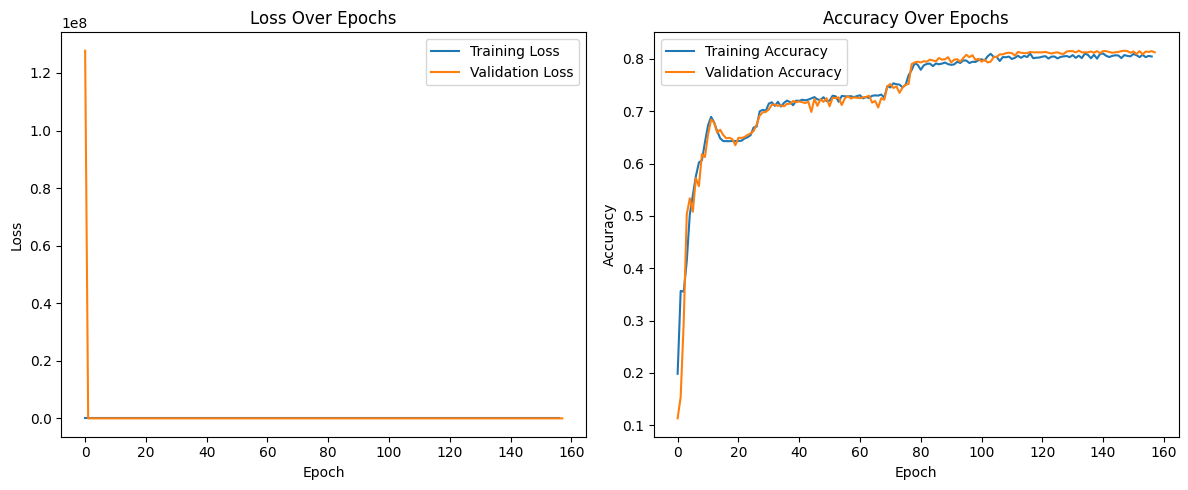

In [23]:
history_callback.plot_history()

# Saving the model

In [24]:
# save pytorch lightening model
trainer.save_checkpoint("cnn_mlp_8g.ckpt")

In [28]:
# 'Depth','Total Activations', 'Total_Activations_Batch_Size', 'Total Parameters', 'Batch Size',
#         'Conv2d Count', 'BatchNorm2d Count', 'Dropout Count', 'activation_encoding_sin',
#         'activation_encoding_cos'

def validate_model(classifier_model):
    classifier_model.eval()
    pred_list, gt = list(), list()
    with torch.no_grad():
        for test_data in test_dataloader:
            pred = classifier_model(test_data[0])
            # if test_data[1].item() != torch.argmax(pred, 1).item():
                # print(test_data[0][0][1])
                # print(f"prediction: {torch.softmax(pred, 1)}, ground truth: {test_data[1]}", (((test_data[0][0][1] * test_data[0][0][4] + test_data[0][0][3]) + (test_data[0][0][3] * test_data[0][0][4]))*4)/(1024**2) )
            gt.append(test_data[1].item())
            pred_list.append(torch.argmax(pred, 1).item())
    return gt, pred_list

gt, pred_list = validate_model(classifier_model)

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
def below_diagonal_sum_rate(confusion_matrix):
    # Convert to a numpy array for easier manipulation if not already
    confusion_matrix = np.array(confusion_matrix)

    # Sum the elements below the main diagonal (excluding the diagonal itself)
    below_diag_sum = np.sum(np.tril(confusion_matrix, k=-1))

    # Get the total number of data points
    total_data_points = np.sum(confusion_matrix)

    # Calculate the rate by dividing below-diagonal sum by total data points
    rate = below_diag_sum / total_data_points

    return rate

def calculate_metrics(gt, preds):
    # Calculate the various metrics
    accuracy = accuracy_score(gt, preds)
    precision = precision_score(gt, preds, average='weighted')  # Use 'weighted' to handle class imbalance
    recall = recall_score(gt, preds, average='weighted')
    f1 = f1_score(gt, preds, average='weighted')
    cm = confusion_matrix(gt, preds)

    # Print the results
    print("Accuracy: {:.4f}".format(accuracy))
    print("Precision: {:.4f}".format(precision))
    print("Recall: {:.4f}".format(recall))
    print("F1-Score: {:.4f}".format(f1))
    print("Below Diagonal Sum Rate: {:.4f}".format(below_diagonal_sum_rate(cm)))
    print("\nConfusion Matrix:")
    print(cm)

    # Full classification report
    print("\nClassification Report:")
    print(classification_report(gt, preds))

calculate_metrics(gt, pred_list)


Accuracy: 0.7997
Precision: 0.7591
Recall: 0.7997
F1-Score: 0.7733
Below Diagonal Sum Rate: 0.1295

Confusion Matrix:
[[129  13   0   0   0   0]
 [  6  81   3   0   0   0]
 [  0  21  24   0   1   1]
 [  0   3  39   0  11   0]
 [  0   0  14   0  20  18]
 [  0   0   1   0   2 277]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       142
         1.0       0.69      0.90      0.78        90
         2.0       0.30      0.51      0.38        47
         3.0       0.00      0.00      0.00        53
         4.0       0.59      0.38      0.47        52
         5.0       0.94      0.99      0.96       280

    accuracy                           0.80       664
   macro avg       0.58      0.62      0.59       664
weighted avg       0.76      0.80      0.77       664



/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/minic

# load from checkpoint 

In [32]:
loaded_model = classification_gpu_usage.load_from_checkpoint(checkpoint_path='cnn_mlp_8g.ckpt', output_size = len(labels))
gt, pred_list = validate_model(loaded_model)
calculate_metrics(gt, pred_list)

Accuracy: 0.7997
Precision: 0.7591
Recall: 0.7997
F1-Score: 0.7733
Below Diagonal Sum Rate: 0.1295

Confusion Matrix:
[[129  13   0   0   0   0]
 [  6  81   3   0   0   0]
 [  0  21  24   0   1   1]
 [  0   3  39   0  11   0]
 [  0   0  14   0  20  18]
 [  0   0   1   0   2 277]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93       142
         1.0       0.69      0.90      0.78        90
         2.0       0.30      0.51      0.38        47
         3.0       0.00      0.00      0.00        53
         4.0       0.59      0.38      0.47        52
         5.0       0.94      0.99      0.96       280

    accuracy                           0.80       664
   macro avg       0.58      0.62      0.59       664
weighted avg       0.76      0.80      0.77       664



/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/dl/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/minic